<a href="https://colab.research.google.com/github/dTenebrae/neural_networks/blob/hw8/hw8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети
    * VAE на fashion_MNIST
    * GAN на одном классе CIFAR

In [ ]:
!pip install -U tensorflow-addons
!pip install -q "tqdm>=4.36.1"

     |████████████████████████████████| 1.1 MB 8.1 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Reshape, Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

from tensorflow.keras.datasets import cifar10, fashion_mnist

import matplotlib.pyplot as plt

from IPython.display import clear_output
from ipywidgets import interact # slide bar

import tensorflow_addons as tfa
import tqdm

In [ ]:
# quietly deep-reload tqdm
import sys
from IPython.lib import deepreload 

stdout = sys.stdout
sys.stdout = open('junk','w')
deepreload.reload(tqdm)
sys.stdout = stdout

tqdm.__version__

'4.62.3'

In [ ]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

### VAE

In [ ]:
# Кастомный слой для сэмплинга из распределения
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# класс для объединения энеокдера и декодера
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Sampling.call of <__main__.Sampling object at 0x7fe7a9ab3910>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method Sampling.call of <__main__.Sampling object at 0x7fe7a9ab3910>>. Not

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())
vae.fit(mnist_digits, epochs=10, batch_size=128, callbacks=[tqdm_callback], verbose='off')
clear_output()

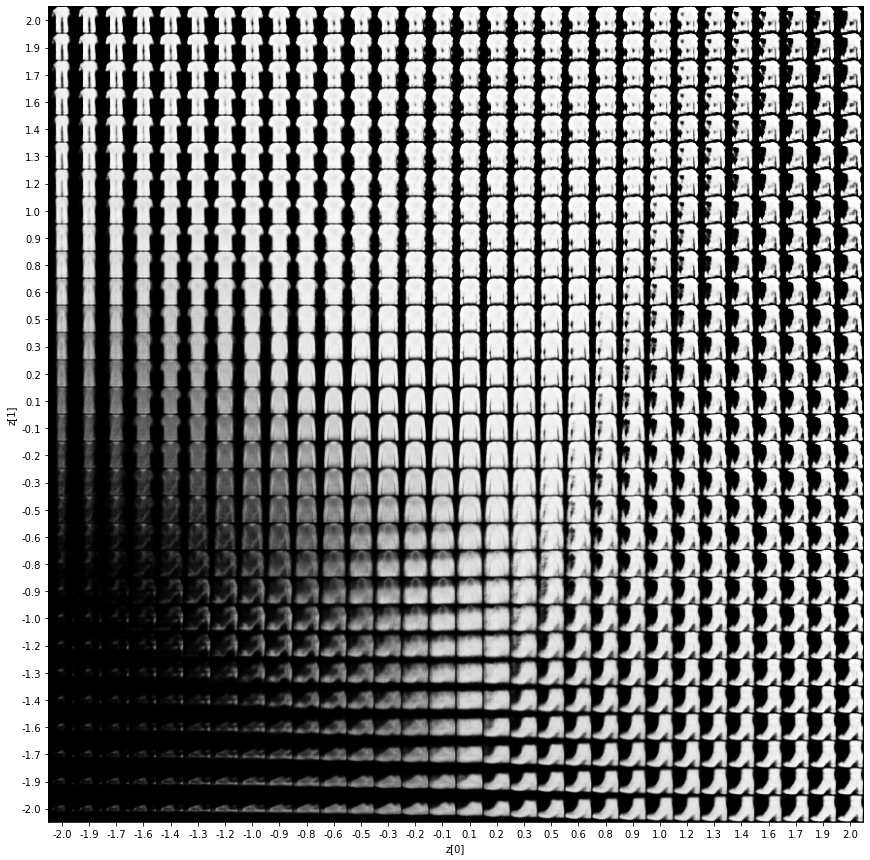

In [ ]:
plot_latent(encoder, decoder)

In [ ]:
def draw_fmnist(x, y):
    x_decoded = decoder.predict([[x, y]])
    plt.imshow(x_decoded[0,:,:,0], cmap='gray_r')
    plt.show()
    
_ = interact(
    draw_fmnist,
    x=(-5, 5, 0.1),
    y=(-5, 5, 0.1)
    )


interactive(children=(FloatSlider(value=0.0, description='x', max=5.0, min=-5.0), FloatSlider(value=0.0, descr…

### GAN

In [ ]:
# определяем дискриминатор
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# генератор
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    model.compile(optimizer=Adam())
    return model
 
# Объединяем
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# Читаем данные из датасета
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = cifar10.load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X
 
# Настоящие картинки(маркируем пиксели единицами)
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y
 
# генерируем точки латентного пространства
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# Генерируем фейковые картинки, помечаем пиксели нулями
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y
 
# сохраняем сгенерированную картинку
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# подготавливаем реальные картинки с меткой 1
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# Считаем скор дискриминатора на реальных картинках
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# Генерируем фейковые картинки с классом 0
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# Считаем скор дискриминатора на фейковых картинках
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# печатаем скоры
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# Сохраняем сгенерированную картинку
	save_plot(x_fake, epoch)
	# Делаем чекпойнт генератора
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)
 
# тренируем генератор и дискриминатор
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # Берем реальные картинки с меткой 1
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # Тренируем дискриминатор на них
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # Теперь генерируем фейковые картинки с меткой 0
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # Обучаем дискриминатор уже на них
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # Создаем для генератора точки скрытого пространства
            X_gan = generate_latent_points(latent_dim, n_batch)
            # Вешаем метки на них
            y_gan = np.ones((n_batch, 1))
            # Обучаем на этом генератор
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # Статистика по лоссам
            if (j+1) % 10 == 0:
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                    (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if (i+1) % 10 == 0:
            clear_output()
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200)

>Accuracy real: 65%, fake: 94%


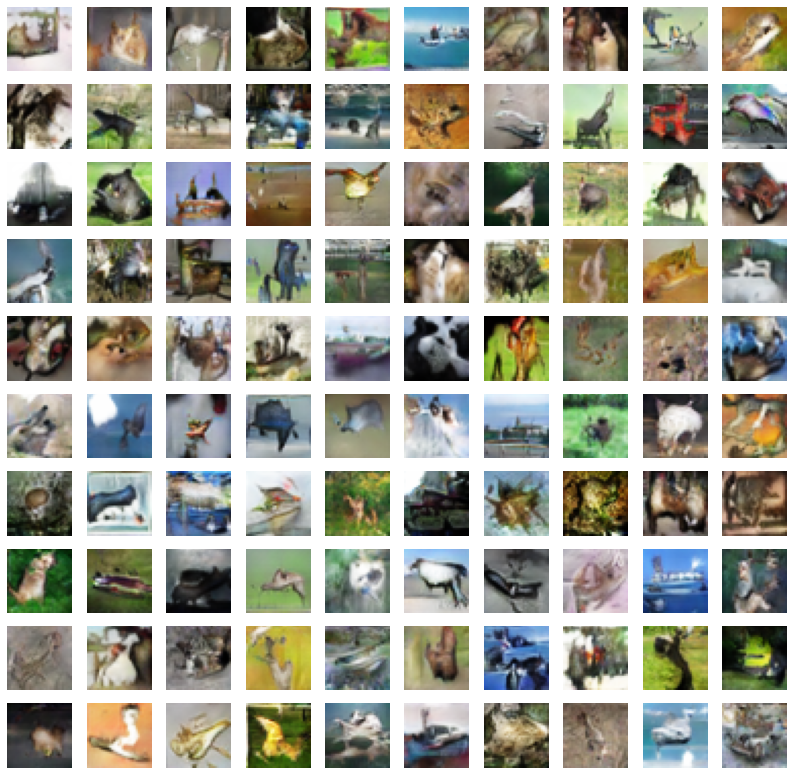

In [ ]:
plt.figure(figsize=(14, 14))
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :])
	plt.show()
 
# load model
model = load_model('generator_model_200.h5')
# model = g_model
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

In [ ]:
latent_points = generate_latent_points(100, 100)
X = model.predict(latent_points)
X = (X + 1) / 2.0

def draw_gan_cifar(x):
    plt.imshow(X[x, :, :])
    plt.show()
    
_ = interact(
    draw_gan_cifar,
    x=(-latent_dim, latent_dim - 1, 1),
    )

interactive(children=(IntSlider(value=-1, description='x', max=99, min=-100), Output()), _dom_classes=('widget…

___

2. Сделайте краткий обзор научной работы, посвящённой алгоритму нейронных сетей, 	 не рассматриваемому ранее на курсе. Проведите анализ: чем отличается выбранная архитектура от других? В чём плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при её применении на практике?

## Трансформеры

Разберем <a href='https://arxiv.org/pdf/1706.03762.pdf'>работу</a>, посвященную архитектуре нейросетей, предназначеных для обработки последовательностей, под названием *Attention Is All You Need*  

В ней предложено отказаться от использования рекуррентных или сверточных сетей и использовать архитекутру под названием *attention* (внимание)


Общая структура сети выглядит следующим образом

![](https://habrastorage.org/r/w1560/webt/59/f0/44/59f04410c0e56192990801.png)

### Краткое описание идеи

Во-первых, вся последовательность на вход (inputs) подается одновременно, плюс к тому, выходная также подается в это время (со сдвигом)

Так как обрабатывается последовательность, то есть необходимость неким образом закодировать, где какая часть находится. Дли этого используется *Positional Encoding* вида:  

$$ PE_{(pos, 2i)} = \sin(pos/10000^{2i/d_{model}}) $$
$$ PE_{(pos, 2i+1)} = \cos(pos/10000^{2i/d_{model}}) $$  

где,  
$pos$ - позиция элемента  
$i$ - dim

Далее, получившиеся эмбеддинги отправляются на вход энкодера и декодера.

Оба состоят из $N$ одинаковых слоев (в работе $N=6$). Каждый слой состоит из 2-х подслоев в случае энкодера и 3-х в случае декодера.

Основную роль здесь играет *Multi-Head Attention*, сильно упрощенный смысл работы которого заключается в том, что он предоставляет для каждого элемента выходной последовательности наиболее релевантные элементы входной. Авторы *attention* говорили, что рекуррентным нейросетям достаточно сложно развернуть фактически всю поледовательность из одного скрытого состояния, поэтому они предложили механизм, в котором кроме скрытого состояния передается еще и информация, релевантная для конкретного элемента.

![](https://habrastorage.org/r/w1560/webt/59/f0/44/59f0440f1109b864893781.png)

Технически на вход этого слоя подаются ключей (K - keys), значений (V - values) и запросов (Q - queries). Ключи и значения это фактически один вектор, в котором ключи это индексирование. Умножая матрицы $Q \cdot K^T$ и пропуская через softmax мы получим вектор для выбора значений из $V$

![](https://wiki.aidungeon.io/images/b/bb/Scaled_Dot-Product_Attention.png)

Это механизм обычного attention. В данной работе используется h-слойный вариант, который повторяет описанное в предыдущем абзаце с разными весами, после чего через линейное преобразование все это сжимается до размерности вектора эмбеддинга

В декодере на второй слой attention в качестве матриц V, K приходит выход с энкодера,а в качестве Q - выход с первого attention декодера.

Как схематично выглядит процесс кодирования/декодирования предложения показано в <a href='https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html'>блоге Google</a>  

![](https://3.bp.blogspot.com/-aZ3zvPiCoXM/WaiKQO7KRnI/AAAAAAAAB_8/7a1CYjp40nUg4lKpW7covGZJQAySxlg8QCLcBGAs/s640/transform20fps.gif)

### Плюсы/Минусы  

К достоинствам можно отнести:  

- возможность распараллеливания вычислений при обработке последовательностей и, как следствие, эффективного обучений сети
- снижение вычислительной нагрузки
- результаты, превосходящий сети на основе классических RNN, LSTM и GRU

К недостаткам относят:
- Неспособность обрабатывать входные данные последовательно (так как, например, предложение обрабатывается все целиком)
- Сложность работы с иерархическими структурами

### Выводы

В настоящее время, через 4 года после публикации, трансформеры представлены повсеместно, от систем машинного перевода, до систем детектирования объектом, сегментации изображений и т.д., что говорит о жизнеспособности этой архитектуры